https://github.com/freedaemons/hwz-scrape

In [1]:
import requests as re
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
from datetime import datetime

In [2]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [3]:
def getThreads(forum_url,forum_df):
    lastForumPage = False
    # forum_cols = ['forum_url', 'thread', 'thread_url']
    # forum_df = pd.DataFrame(columns=forum_cols)
    forum_page_url = forum_url
    while(not lastForumPage):
        r2 = re.get(forum_page_url)
        forum_page = r2.text
        forum_page_soup = BeautifulSoup(forum_page, 'html.parser')

        if (forum_page_soup.find('a', text='Next ›') == None):
            lastForumPage = True
        else:
            forum_page_url = site_url + forum_page_soup.find('a', text='Next ›')['href']

        for element in forum_page_soup.find_all('a', {"id": lambda x: x and 'thread_title_' in x}):
            row = pd.DataFrame([[forum_url, element.contents[0], site_url + element['href']]], columns=forum_cols)
            if(len(forum_df)==0):
                forum_df = row
            else:
                forum_df = forum_df.append(row, ignore_index=True) #df.append doesn't work inplace
    return forum_df

Relevant Forums to get neighbourhood sentiment

https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/



In [4]:
relevant_threads = ['https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/']

site_url = 'https://forums.hardwarezone.com.sg'                    

In [5]:
%%time
forum_cols = ['forum_url', 'thread', 'thread_url']
forum_df = pd.DataFrame(columns=forum_cols)

for link in relevant_threads:
  forum_df = getThreads(link,forum_df)

CPU times: user 4.99 s, sys: 62.2 ms, total: 5.05 s
Wall time: 41.6 s


In [6]:
forum_df.loc[forum_df['forum_url'] == 'https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/' ,'forum'] = 'homeseekers-homemakers'

In [7]:
print(len(forum_df))

1360


In [8]:
forum_no_emoji = forum_df.copy()

In [ ]:
#     myre = re.compile(u'['u'\ud83c']+',
#                           u'\U0001F300-\U0001F64F'
#                           u'\U0001F680-\U0001F6FF'
#                           u'\u2600-\u2B55'
#                           u'\u23cf'
#                           u'\u23e9'
#                           u'\u231a'
#                           u'\u3030'
#                           u'\ufe0f'
#                           u'\ude18'
#                           u'\udd29'
#                           u'\ud83d'
#                           u'\ud83e'
#                           u'\ude14'
#                           u'\udc99'
#                           u'\ude02'
#                           u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                             u'\U00010000-\U0010ffff'
#                            u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
#                            u'\U00002702-\U000027B0]+',     
#                           re.UNICODE)

# forum_no_emoji['thread'] = forum_no_emoji['thread'].apply(remove_emoji)
# forum_no_emoji['forum_url'] = forum_no_emoji['forum_url'].apply(remove_emoji)
# forum_no_emoji['thread_url'] = forum_no_emoji['thread_url'].apply(remove_emoji)

In [17]:
import re as rec

In [20]:
#Remove emoji before saving to csv file or will have encode error
# https://zhuanlan.zhihu.com/p/41213713

def remove_emoji(text):

    myre = rec.compile(u'[\ud83c'
                      u'\ud83d]+'
                      , re.UNICODE)
  
    text = myre.sub(' ', text)
    return text
        
forum_no_emoji['thread'] = forum_no_emoji['thread'].apply(remove_emoji)

In [ ]:
forum_no_emoji.to_csv("allthreads.csv", encoding='utf-8', index=False)

In [ ]:
allThreads_df = pd.read_csv('allthreads.csv')
print(len(allThreads_df))
allThreads_df.head()

In [ ]:
allThreads_df['thread'] = allThreads_df['thread'].str.replace(r'\r|\n|\t',' ')

In [ ]:
#Remove GAGT/PCWX app automatic signatures
allThreads_df['thread'].replace(r'Sent from .* using GAGT', '', inplace = True, regex=True) 
allThreads_df['thread'].replace(r'Posted from PCWX using .*', '', inplace = True, regex=True) 
# ^^ will not remove the entire phone model but as much as possible try 
allThreads_df['thread'].replace(r'Posted with .* via PCWX', '', inplace = True, regex=True)

In [ ]:
allThreads_df['thread'] = allThreads_df['thread'].apply(lambda x: ' '.join([word.lower() for word in str(x).split()])) 

In [ ]:
allThreads_df['thread'].replace('', np.nan, inplace = True) #replace empty strings with NaN
allThreads_df.dropna(inplace = True) #Drop NaN rows (originally empty strings)

In [ ]:
allThreads_df['thread'].size

713

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.corpus import wordnet as wn

mapping = {'n': 'noun', 'v': 'verb', 's': 'adj (sat)', 'a': 'adj', 'r': 'adv'}

In [ ]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
allThreads_df['thread'] = allThreads_df['thread'].apply(lambda x: clean_text(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
allThreads_df['thread']

0         three adjacent land house telok kurau sell mil
1      three adjoin conservation shophouses kampong g...
2      three adjoin freehold shophouses river valley ...
3      three adjoin mixed development site near botan...
4      three adjoin shophouses along syed alwi road s...
                             ...                        
708                                    ethic resale unit
709                                     reef king's dock
710                                 sail@marina transact
711                                             wisteria
712                     thought sengkang grand residence
Name: thread, Length: 713, dtype: object

In [ ]:
def getPosts(thread_url):
    #print(thread_url)
    lastThreadPage = False
    thread_cols = ['thread_url', 'userid', 'timestamp', 'post_text', 'post_number', 'post_id', 'first_quote_post_number'] # 'likes_userid'
    thread_df = pd.DataFrame(columns=thread_cols)
    thread_page_url = thread_url

    while (not lastThreadPage):

        r3 = re.get(thread_page_url)
        thread_page = r3.text
        thread_page_soup = BeautifulSoup(thread_page, 'html.parser')

        if (thread_page_soup.find('a', text='Next ›') == None):
            lastThreadPage = True
        else:
            thread_page_url = site_url + thread_page_soup.find('a', text='Next ›')['href']

        thread_page_posts = thread_page_soup.find('div', {'id': 'posts'})
        
        try: 
            for post in thread_page_posts.find_all('div', {'class': 'post-wrapper'}):
                userid_url = post.find('a', {'class': 'bigusername'})['href']
                userid = ''.join(filter(lambda x: x.isdigit(), userid_url))

                datetime_raw = post.find('a', {'name': lambda x: x and x.find('post') == 0}).nextSibling.strip()
                date_list = datetime_raw.split(',')[0].split('-')
                iso_date = '-'.join(list(reversed(date_list)))
                hour = int(datetime_raw.split(' ')[1][0:2])
                if(datetime_raw.split(' ')[2] == 'PM' and hour < 12):
                    hour += 12
                hour_str = str(hour)
                if(hour < 10):
                    hour_str = '0' + str(hour)
                minute = datetime_raw.split(':')[1][0:2]
                iso_datetime = iso_date + 'T' + hour_str + ':' + minute

                post_text = ""
                try:
                    post_text = post.find('div', {'class': 'post_message'}).get_text(' ', strip=True)
                except AttributeError as e: 
                    pass

                post_number = int(post.find('a', {'id': lambda x: x and 'postcount' in x, 'target': 'new'}).find('strong').get_text())

                post_id = int(post.find('a', {'id': lambda x: x and 'postcount' in x, 'target': 'new'})['id'].lstrip('postcount'))
                
                first_quote_post_number = np.nan
                try:
                    first_quote = post.find('div', {'class': 'quote'})
                    first_quote_post_number = first_quote.find('span', {'class': 'byline'}).find('a')['href'].split('#')[1].lstrip('post')
                except:
                    pass
                
                row = pd.DataFrame([[thread_url, userid, iso_datetime, post_text, post_number, post_id, first_quote_post_number]], columns=thread_cols)
                if(len(thread_df)==0):
                    thread_df = row
                else:
                    thread_df = thread_df.append(row, ignore_index=True) #df.append doesn't work inplace
        except:
            row = pd.DataFrame([[thread_url, "", "", "", np.nan, np.nan, np.nan]], columns=thread_cols) #posts missing, thread may have been deleted
            if(len(thread_df)==0):
                thread_df = row
            else:
                thread_df = thread_df.append(row, ignore_index=True) #df.append doesn't work inplace
    thread_df['post_text'] = thread_df['post_text'].map(lambda x: x.encode('unicode-escape').decode('utf-8'))

    return thread_df

In [ ]:
links = allThreads_df['thread_url']
links

0      https://forums.hardwarezone.com.sg/homeseekers...
1      https://forums.hardwarezone.com.sg/homeseekers...
2      https://forums.hardwarezone.com.sg/homeseekers...
3      https://forums.hardwarezone.com.sg/homeseekers...
4      https://forums.hardwarezone.com.sg/homeseekers...
                             ...                        
708    https://forums.hardwarezone.com.sg/homeseekers...
709    https://forums.hardwarezone.com.sg/homeseekers...
710    https://forums.hardwarezone.com.sg/homeseekers...
711    https://forums.hardwarezone.com.sg/homeseekers...
712    https://forums.hardwarezone.com.sg/homeseekers...
Name: thread_url, Length: 713, dtype: object

In [ ]:
%%time
thread_cols = ['thread_url', 'userid', 'timestamp', 'post_text', 'post_number', 'post_id', 'first_quote_post_number'] # 'likes_userid'
all_comments_df = pd.DataFrame(columns=thread_cols)

for i in links:
  post = getPosts(i)
  all_comments_df = all_comments_df.append(post, ignore_index=True)

CPU times: user 11min 32s, sys: 4.65 s, total: 11min 37s
Wall time: 1h 49min 18s


In [ ]:
# all_comments_df['post_text'] = all_comments_df['post_text'].apply(remove_emoji)
all_comments_df.to_csv("all_comments_df.csv", encoding='utf-8', index=False)

In [ ]:
from google.colab import files
files.download("all_comments_df.csv") 

Preprocess all comments csv file


In [22]:
all_comments_df = pd.read_csv('all_comments_df.csv')
print(len(all_comments_df))
all_comments_df.head(15)

95877


,thread_url,userid,timestamp,post_text,post_number,post_id,first_quote_post_number
0,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/three-adjacent-landed-houses-telok-kurau-sold-%2423-6-mil-6442613.html,724092,2021-01-05T23:05,Three adjacent landed houses in Telok Kurau sold for $23.6 mil \x93the developers intend to build 21 residential units on the site.\x93 https://www.edgeprop.sg/property-new...x3ozl1y30vIBCY,1,131803016,NaN
1,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/three-adjacent-landed-houses-telok-kurau-sold-%2423-6-mil-6442613.html,724092,2021-01-05T23:09,Area is under 100sqm GFA rule.,2,131803110,NaN
2,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/three-adjacent-landed-houses-telok-kurau-sold-%2423-6-mil-6442613.html,755799,2021-01-05T23:29,1993newbie wrote: Three adjacent landed houses in Telok Kurau sold for $23.6 mil \x93the developers intend to build 21 residential units on the site.\x93 https://www.edgeprop.sg/property-new...x3ozl1y30vIBCY Estimated to launch 18xxpsf? Saw an earlier article that the area can build about 24 units and land price estimated $900psf.,3,131803442,131803016.0
3,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/three-adjacent-landed-houses-telok-kurau-sold-%2423-6-mil-6442613.html,592156,2021-01-05T23:48,1993newbie wrote: Three adjacent landed houses in Telok Kurau sold for $23.6 mil \x93the developers intend to build 21 residential units on the site.\x93 https://www.edgeprop.sg/property-new...x3ozl1y30vIBCY Is it enbloc houses land to build apartment?,4,131803782,131803016.0
4,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/three-adjoining-conservation-shophouses-kampong-glam-market-%247-64-mil-6386901.html,775617,2020-10-05T08:15,"Three adjoining conservation shophouses in Kampong Glam are up for sale at $7.64 million, or $3,000 psf, according to CBRE, which is marketing the properties",1,130098104,NaN
5,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/three-adjoining-freehold-shophouses-river-valley-road-sale-%2421-9-mil-6397449.html,775617,2020-10-23T07:26,"Three adjoining shophouses along River Valley Road are up for sale at a guide price of $21.9 million, or $2,500 psf based on the built-up area of 8,778 sq ft. https://www.edgeprop.sg/property-new...n=forumposting",1,130417914,NaN
6,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/three-adjoining-mixed-development-sites-near-botanic-gardens-collective-sale-%2462-5-mil-6455770.html,775617,2021-01-28T09:35,"Three adjoining, mixed-use redevelopment sites near the Botanic Gardens MRT Interchange Stations \x97 551 to 553 Bukit Timah Road, 6 to 8 Duke Road and a driveway \x97 have been put up for sale by tender. All the owners have agreed to the collective sales of their respective freehold developments, which means that no Strata Title Board application for a sale order is required. https://www.edgeprop.sg/property-new...n=forumposting",1,132227553,NaN
7,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/three-adjoining-shophouses-along-syed-alwi-road-sale-%248-8-mil-6356313.html,775617,2020-08-14T08:03,"Three adjoining two-storeyed shophouses on Syed Alwi Road are on the market at a guide price of $8.8 million, according to marketing agent Edmund Tie. https://www.edgeprop.sg/property-new...n=forumposting",1,129092807,NaN
8,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/three-conservation-shophouses-jalan-sultan-market-%249-38-mil-6399276.html,775617,2020-10-26T08:31,"Three intermediate shophouses along Jalan Sultan are on sale at a collective guide price of $9.38 million. The leasehold shophouses will be put up for auction by Knight Frank on Oct 30. These properties can be acquired either individually or collectively, says Tricia Tan, the deputy director of auction and sales at Knight Frank. https://www.edgeprop.sg/property-new...n=forumposting",1,130474110,NaN
9,https://forums.hardwarezone.com.sg/homeseekers-homema

In [47]:
all_comments_df['post_text'].isnull().values.any()

True

In [49]:
all_comments_df = all_comments_df[all_comments_df['post_text'].notna()]
all_comments_df['post_text'].isnull().values.any()
print(len(all_comments_df))

95693


In [60]:
postal_district_num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
general_location = [['Raffles Place', 'Cecil', 'Marina', "People\'s Park", "Boat Quay", "Chinatown", "Havelock Road", "Suntec City"],
                    ['Anson', 'Tanjong Pagar', 'Neil Road', "Shenton Way"],
                    ['Bukit Merah', 'Queenstown', 'Tiong Bahru', "Alexandra Road"],
                    ['Telok Blangah', 'Harbourfront', 'Keppel', "Mount Faber", "Sentosa"],
                    ['Buona Vista', 'Dover', 'Pasir Panjang', "West Coast", "Hong Leong Garden", "Clementi"],
                    ['High Street', 'Beach Road', 'City Hall', "North Bridge Road"],
                    ['Middle Road', 'Golden Mile', 'Bencoolen Road', "Bugis", "Rochor"],
                    ['Little India', 'Farrer Park', 'Jalan Besar', "Lavender"],
                    ['Orchard', 'Cairnhill', 'River Valley', "Killiney", "Leonie Hill", "Oxley"],
                    ['Ardmore', 'Bukit Timah', "Balmoral", "Boat Quay", "Grange Road", "Holland", "Tanglin"],
                    ['Watten Estate', 'Thomson', "Chancery", "Bukit Timah", "Dunearn Road", "Newton"],
                    ['Balestier', 'Moulmein', 'Novena', "Toa Payoh", "Serangoon"],
                    ['Macpherson', 'Braddell', 'Potong Pasir', "Bidadari"], 
                    ['Geylang', 'Eunos', 'Kembangan', "Paya Lebar", "Aljunied"], 
                    ['Katong', 'Joo Chiat', 'Amber Road', "Marine Parade", "Siglap", "Tanjong Rhu"],
                    ['Bedok', 'Upper East Coast', 'Eastwood', "Kew Drive", "Bayshore", "Chai Chee"], 
                    ['Loyang', 'Changi'],
                    ['Simei', 'Tampines', 'Pasir Ris'],
                    ['Serangoon Garden', 'Hougang', 'Punggol', 'Sengkang'],
                    ['Ang Mo Kio', 'Bishan', 'Braddell Road', "Thomson"],
                    ['Upper Bukit Timah', 'Ulu Pandan', "Hume Avenue"],
                    ['Penjuru', 'Jurong', 'Pioneer', "Tuas", "Boon Lay"],
                    ['Hillview', 'Dairy Farm', 'Bukit Panjang', "Choa Chu Kang", "Bukit Batok"], 
                    ['Lim Chu Kang', 'Tengah', 'Kranji', "Sungei Gedong"], 
                    ['Woodgrove', 'Woodlands', 'Admiralty','Kranji'],
                    ['Upper Thomson', 'Springleaf', 'Tagore', "Yio Chu Kang"],
                    ['Yishun', 'Sembawang', 'Senoko'],
                    ['Seletar']]

postal_district = {postal_district_num[i]: general_location[i] for i in range(len(postal_district_num))}   

Data- Preprocessing


In [52]:
#Remove duplicate rows
all_comments_df['post_id'].drop_duplicates(inplace=True)
#Remove GAGT/PCWX app automatic signatures
all_comments_df['post_text'].replace(r'Sent from .* using GAGT', '', inplace = True, regex=True) 
all_comments_df['post_text'].replace(r'Posted from PCWX using .*', '', inplace = True, regex=True) 
# ^^ will not remove the entire phone model but as much as possible try 
all_comments_df['post_text'].replace(r'Posted with .* via PCWX', '', inplace = True, regex=True)

In [57]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
all_comments_df['post_text'] = all_comments_df['post_text'].apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Finding all relevant comments that contains name of each location in each district and assigning a district number


In [61]:
%%time
thread_cols = ['thread_url', 'userid', 'timestamp', 'post_text', 'post_number', 'post_id', 'first_quote_post_number','district_num'] # 'likes_userid'
all_comments_relevant = pd.DataFrame(columns=thread_cols)

for key, values in postal_district.items():
  temp_df = all_comments_df[all_comments_df['post_text'].str.contains('|'.join(values), case=False)]   #not case sensitive
  temp_df['district_num'] = key
  all_comments_relevant = all_comments_relevant.append(temp_df, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


CPU times: user 38.1 s, sys: 14.4 ms, total: 38.1 s
Wall time: 38.1 s


In [62]:
all_comments_relevant.district_num.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=object)

In [63]:
all_comments_relevant.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)

district_num
19    3397
18    2226
14    1599
5     1509
27    1398
12    1071
20    982 
13    898 
10    742 
11    702 
23    676 
22    638 
24    614 
4     543 
16    497 
9     462 
3     457 
25    433 
1     362 
7     282 
15    277 
17    275 
28    166 
2     118 
8     111 
21    94  
6     63  
26    59  
Name: post_id, dtype: int64

In [64]:
all_comments_relevant.to_csv("all_relevant_comments.csv", encoding='utf-8', index=False)

In [65]:
#Getting comments from 2018 to 2021
year_2018 = all_comments_relevant[all_comments_relevant['timestamp'].str.contains("2018")] 
year_2019 = all_comments_relevant[all_comments_relevant['timestamp'].str.contains("2019")] 
year_2020 = all_comments_relevant[all_comments_relevant['timestamp'].str.contains("2020")] 
year_2021 = all_comments_relevant[all_comments_relevant['timestamp'].str.contains("2021")]

In [66]:
year_2018

,thread_url,userid,timestamp,post_text,post_number,post_id,first_quote_post_number,district_num
61,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/conveyancing-lawyer-recommendation-5898756.html,560738,2018-09-16T08:56,juniorlion write anyone reliable conveyance lawyer recommend thanks need leg work go law firm offer free consultation matter spread toa payoh chinatown city hall area etc fifth firm know law firm operate difference fee quote one comfortable etc,25,116528179,116417774.0,1
72,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/free-advice-discussion-buy-sell-resale-flat-part-6-a-4229748.html,730621,2018-09-12T07:39,henrylbh write let go flat level hougang move condition toilet complete upgrading mon want si flat top storey flat bedok resevoir hr ntuc shen siong mrt less min walk thanks offer i'm look chinatown area,7119,116459874,116459151.0,1
151,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/official-november-2017-bto-5665295.html,591664,2018-01-06T11:36,write i'm sure pple dun like punggol i'm currently punggol ballot another punggol flat current place oso near rental flat problem whatsoever live sleepy mini town punggol plaza one big shop ctr everything need get yeah back mind also consider amenity around punggol bto near waterway point across small road go new northshore mall lrt also front convenient marina country club also downstairs concern factory area nearby dusty air pollution also view seem like nice overlook seletar island factory direction overlook lrt track new university time come anyone know,950,112164809,112164611.0,1
152,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/official-november-2017-bto-5665295.html,246183,2018-01-06T12:11,kelvin_som write yeah back mind also consider amenity around punggol bto near waterway point across small road go new northshore mall lrt also front convenient marina country club also downstairs concern factory area nearby dusty air pollution also view seem like nice overlook seletar island factory direction overlook lrt track new university time come anyone know urge think twice search hundred thread starter ppl die get mop big peak jam see towards tpe add another ppl next year fume mozzies distance town food list go,951,112165274,112164809.0,1
153,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/official-november-2017-bto-5665295.html,695251,2018-02-08T23:17,gladtoknowmore write think term price pay get industrial area paya lebar eunos prolly gonna go make way paya lebar next cbd see ura master plan eunos court plot really prime also closer east coast stadium east side foodie place people pay uni think remain industry estate mrt ride also slightly longer hit town immaterial think like redhill napier road parallel around time town price lot different two cent worth vested eunos court thanks two cent i'm aware ura master plan truth paya lebar cbd extend across exist industrial estate demand get idea see slow exist cbd extend across marina bay furthermore jurong compete main problem i'm vest dakota bto fact eunos cost make sense expect eunos project cheap shock find price also shock arrangement south face eunos unit directly orient towards old block sardine say ihope good number eunos get unit want,1443,112736867,112736627.0,1
...,...,...,...,...,...,...,...,...
20676,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/rivercove-residences-5695984.html,542556,2018-04-15T06:25,write really wise buy rivercove firstly overprice secondly location really fantastic compare ec near mrt nature ec lrt nearby still need change train take mrt park small park crowd times longer become exclusive thirdly pay much interior disappointment interior forthly shop mall walk distance nothing around vicinity besides church coffee shop sport complex good ec unless friend relative stay area people use stay area want explore part singapore take car start explore make decision good one buy nearby watertown la fiesta jewel@bu

Sentiment Analysis

In [106]:
from textblob import TextBlob

# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    
    # use this line for Python 2 (avoids UnicodeDecodeError for some reviews)
    # blob = TextBlob(text.decode(encoding='utf-8'))
    
    # use this line instead for Python 3
    blob = TextBlob(text)
    
    # return the polarity
    return blob.sentiment.polarity

In [ ]:
year_2018['sentiment'] = year_2018.post_text.apply(detect_sentiment)
year_2018.head(3)

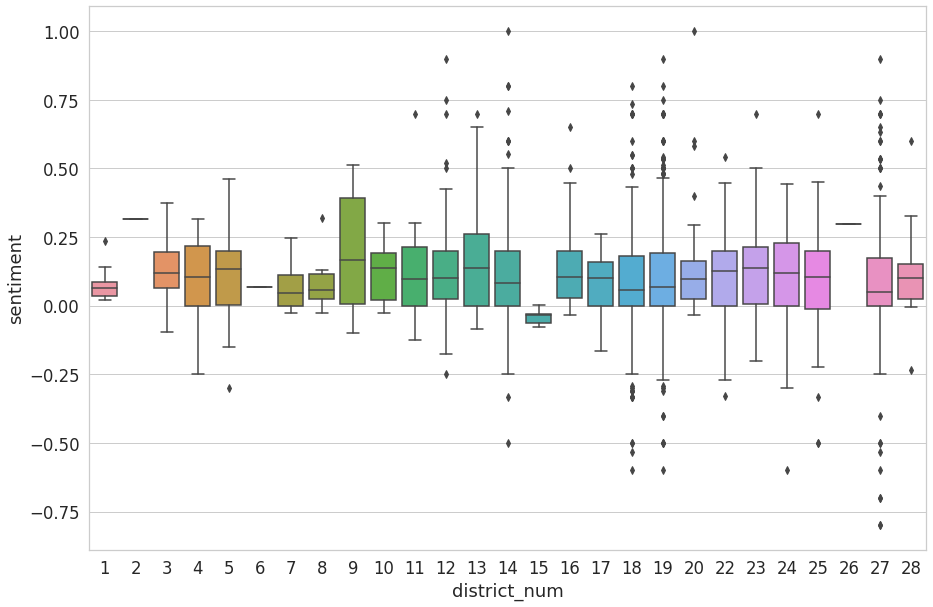

In [91]:
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x="district_num", y="sentiment", data=year_2018);

In [107]:
year_2019['sentiment'] = year_2019.post_text.apply(detect_sentiment)
year_2019.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,thread_url,userid,timestamp,post_text,post_number,post_id,first_quote_post_number,district_num,sentiment
0,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/treasure-tampines-6007933.html,248841,2019-04-10T12:43,nishizhu write haha yea see success duo residence pple buy transact park place another mimic ask many project singapore get attribute like duo plq reason certain project sell last check feb data duo unsold year marina one cross road asia sq work-home-work workaholic choice south beach still sell holland next pasir ri soon hougang maybe....sound like chao agent....ya modern mixdev like queensway shopping ctr,530,120176670,120176386.0,1,0.176786
1,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/treasure-tampines-6007933.html,186395,2019-04-10T14:56,write last check feb data duo unsold year marina one cross road asia sq work-home-work workaholic choice south beach still sell holland next pasir ri soon hougang maybe....sound like chao agent....ya modern mixdev like queensway shopping ctr ask would want pay bedder reflection kinda layout even one best location haha still get big big caption say unblock view,532,120179038,120176670.0,1,0.175000
2,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/treasure-tampines-6007933.html,748249,2019-05-21T09:34,concerned foreign buyer give reason base ura statistic buyer singapore private property non-singaporean/pr mean singapore private property market virtually prop singaporeans/prs ii also anecdotal evidence property agent friends foreign buyer seem target investment high profile traditionally expensive area like orchard bukit timah marina bay look sell within year long term horizon think foreign buyer's consideration look mass market property ocr/rcr area thread concerned,1074,120889440,NaN,1,-0.187750


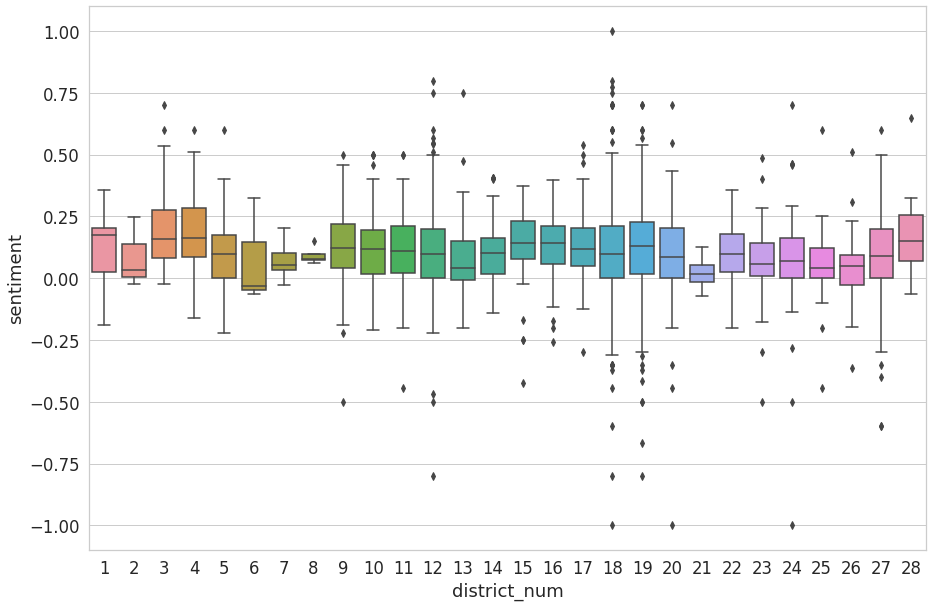

In [108]:
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x="district_num", y="sentiment", data=year_2019);

Year 2020

In [109]:
year_2020['sentiment'] = year_2020.post_text.apply(detect_sentiment)
year_2020.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,thread_url,userid,timestamp,post_text,post_number,post_id,first_quote_post_number,district_num,sentiment
6,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/two-strata-office-floors-gb-building-cecil-street-sale-6315174.html,775617,2020-06-23T08:02,singapore edgeprop two strata office floor level gb building cecil street put sale floor sq ft feature regular column-free layout sale via expression interest close july cbre exclusive marketing agent level currently lease various client indicative price million approximately psf stratum area level indicative price million approximately psf stratum area sell vacant possession immediately occupy owner-occupier clemence lee senior director capital market cbre say compare recent stratum office transaction indicative price two office floor gb building three office floor cbd transacted year level samsung hub million psf stratum area level suntec tower million psf stratum area level suntec tower million psf stratum area cbre expect strong interest investor boutique real estate fund family office high-net-worth individual property zone use mean local foreigner eligible purchase property additional stamp duty stamp duty impose purchase gb build office development situate junction cecil street mccallum street equip three-level basement car park fit maximum vehicle build within three-minute walk shelter walkway link tanjong pagar mrt station east-west line building within close proximity retail f&b entertainment lifestyle establishment nearby development asia square frasers tower capital tower oue downtown well amoy street ann siang hill,1,127928120,NaN,1,-0.006597
34,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/8-st-thomas-direct-developer-freehold-immediate-occupancy-6246453.html,592156,2020-04-03T18:32,develop reputable developer bukit sembawang estates ltd freehold locate near world-renowned orchard road top obtain immediate occupancy rental yield low maintenance fee exclusive residential home high iconic twin tower level sky terrace intermediate level easily accessible upcoming great world city mrt station walk distance somerset mrt connects major road cte cbd marina bay financial centre fort can park american club tanglin club short drive away close local international school river valley primary school within km anglo-chinese school raffle girl secondary school st primary school singapore management university chatsworth international school iss international school,2,126110086,NaN,1,0.184079
36,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/anyone-looking-buy-properties-during-period-wanna-share-tips-6243725.html,774990,2020-05-29T10:23,broadwalk write yes highway noise air pollution time peak hour stretch road lead maple business park quite congest even head nuhs/science park would challenge peak hour though landed property maybe fine condo maybe ideal personal preference cent personally feel pp currently undervalue area singapore long time govt pay much attention residential development pp except build maple tree business park psa port paya lebar stop away marina bay cbd transact pasir panjang also stop away marina bay cbd circle line connect pasir panjang transact psf low risk high upside furthermore circle line connect resident live expensive area like holland village one north pas pp get cbd naturally attract people work cbd look development along circle line unique combination near nature business park cbd simultaneously think many area singapore fulfill qualm primary school within walk distance currently empty plot moe land behind bijou hopefully moe something soon feel viva vista icon waste space one rent commercial stratum title shop ghost town wonder whats solution guy thought,394,127418167,127417898.0,1,0.101902


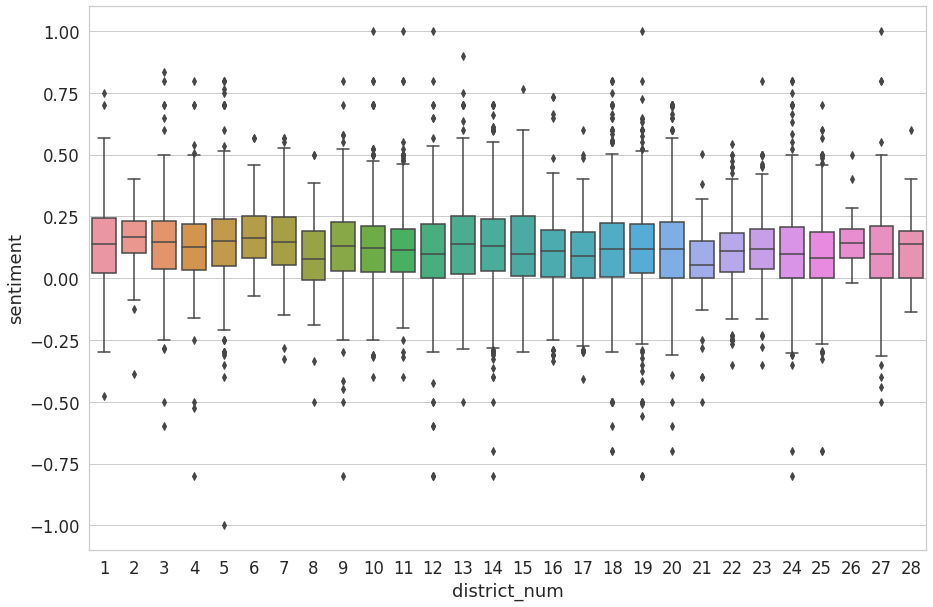

In [110]:
sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')
sns.boxplot(x="district_num", y="sentiment", data=year_2020);

Year 2021

In [111]:
year_2021['sentiment'] = year_2021.post_text.apply(detect_sentiment)
year_2021.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,thread_url,userid,timestamp,post_text,post_number,post_id,first_quote_post_number,district_num,sentiment
7,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/two-bedder-one-shenton-market-%241-65-mil-6457873.html,762914,2021-02-02T20:29,entry pricing original investor sail saw huge upside problem cbd consistent oversupply cap interest marina one make issue worst flood unit unit come bay window large size compare new launch cap price appreciation due quantum think buyer able get still meat table rental yield pretty fantastic unit,8,132325244,NaN,1,0.140065
8,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/uptown-farrer-6336130.html,775832,2021-02-27T08:32,tourist usually visit indian temple chinatown one middle little india serangoon road one near clarke quay,112,132779300,NaN,1,-0.084375
9,https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/condo-choose-6356637.html,290511,2021-01-06T04:45,one marina mil br,15,131805390,NaN,1,0.000000


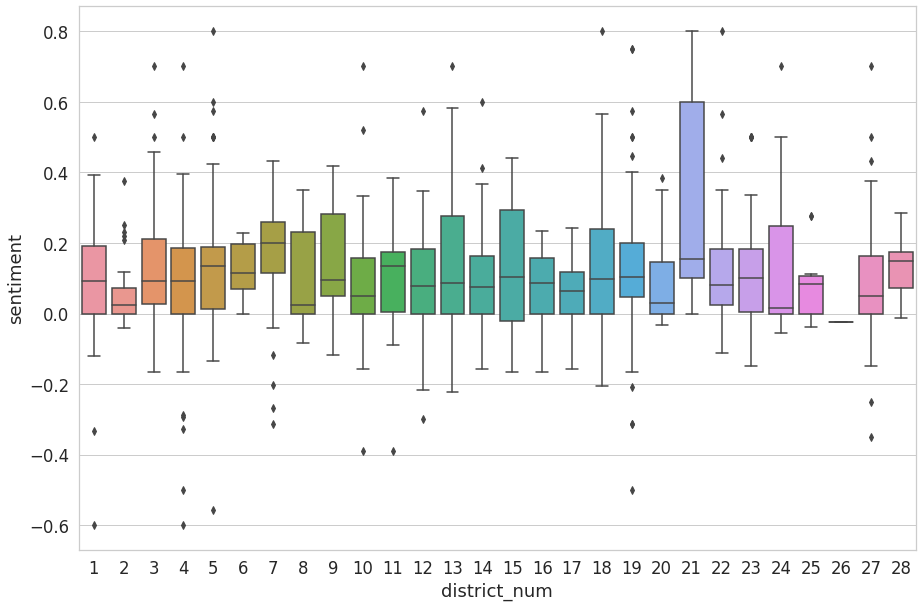

In [112]:
sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')
sns.boxplot(x="district_num", y="sentiment", data=year_2021);

In [113]:
#2018
comment_count_2018 = year_2018.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2018  = pd.DataFrame(comment_count_2018)
mean_district_sentiment_2018 = year_2018.groupby('district_num', as_index=False)['sentiment'].mean()

sentiment_2018 = mean_district_sentiment_2018.merge(comment_count_2018, on='district_num', how='left')
sentiment_2018.columns = ['district_num', 'sentiment', 'comment_count']
sentiment_2018['year'] = 2018

In [114]:
#2019
comment_count_2019 = year_2019.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2019  = pd.DataFrame(comment_count_2019)
mean_district_sentiment_2019 = year_2019.groupby('district_num', as_index=False)['sentiment'].mean()

sentiment_2019 = mean_district_sentiment_2019.merge(comment_count_2019, on='district_num', how='left')
sentiment_2019.columns = ['district_num', 'sentiment', 'comment_count']
sentiment_2019['year'] = 2019

In [115]:
#2020
comment_count_2020 = year_2020.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2020 = pd.DataFrame(comment_count_2020)
mean_district_sentiment_2020 = year_2020.groupby('district_num', as_index=False)['sentiment'].mean()

sentiment_2020 = mean_district_sentiment_2020.merge(comment_count_2020, on='district_num', how='left')
sentiment_2020.columns = ['district_num', 'sentiment', 'comment_count']
sentiment_2020['year'] = 2020

In [116]:
#2021
comment_count_2021 = year_2021.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2021 = pd.DataFrame(comment_count_2021)
mean_district_sentiment_2021 = year_2021.groupby('district_num', as_index=False)['sentiment'].mean()

sentiment_2021 = mean_district_sentiment_2021.merge(comment_count_2021, on='district_num', how='left')
sentiment_2021.columns = ['district_num', 'sentiment', 'comment_count']
sentiment_2021['year'] = 2021

In [117]:
sentiment_list = [sentiment_2018, sentiment_2019, sentiment_2020, sentiment_2021]  # List of your dataframes
hwz_sentiment = pd.concat(sentiment_list)

In [118]:
hwz_sentiment

,district_num,sentiment,comment_count,year
0,1,0.082516,8,2018
1,2,0.317045,1,2018
2,3,0.123678,39,2018
3,4,0.093259,30,2018
4,5,0.122456,61,2018
...,...,...,...,...
23,24,0.150795,21,2021
24,25,0.088860,12,2021
25,26,-0.025054,1,2021
26,27,0.084183,45,2021


In [119]:
hwz_sentiment.to_csv("hwz_sentiment.csv", encoding='utf-8', index=False)

Another Sentiment Analysis approach

In [ ]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
comments_df["sentiments"] = comments_df["Comment"].apply(lambda x: sid.polarity_scores(x))
comments_df = pd.concat([comments_df.drop(['sentiments'], axis=1), comments_df['sentiments'].apply(pd.Series)], axis=1)

In [ ]:
comments_df.head()

In [ ]:
average_negative = comments_df["neg"].mean()
average_negative

In [ ]:
average_positive = comments_df["pos"].mean()
average_positive

In [ ]:
average_neutral = comments_df["neu"].mean()
average_neutral

Another sentiment analysis approach using Afinn

In [ ]:
# In terminal: pip install afinn
from afinn import Afinn

In [ ]:
afinn = Afinn()

In [ ]:
afinn_emo = Afinn(emoticons=True)

In [ ]:
afinn = Afinn()
afinn_scores = [afinn.score(text) for text in year_2018.post_text]

In [ ]:
year_2018['afinn'] = afinn_scores
year_2018[['sentiment', 'afinn', 'content']].head(10)


**Results for Level of Positivity**
% neutral comments
% positive comments
% negative comments

In [ ]:
# generating a wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(comments_df["Comment"])

In [ ]:
# highest positive sentiment reviews
comments_df.sort_values("pos", ascending = False)[["Comment", "pos"]].head(10)

In [ ]:
# highest lowest sentiment reviews
comments_df.sort_values("neg", ascending = False)[["Comment", "neg"]].head(10)